## ПРОЕКТ: ВЫБОР ЛОКАЦИИ ДЛЯ СКВАЖИНЫ

### ОПИСАНИЕ ПРОЕКТА

Заказчик проекта - добывающая компания "ГлавРосГосНефть". Нужно решить, где бурить новую скважину.\
Заказчиком предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны.

### ЗАДАЧА ПРОЕКТА

Нужно построить модель для определения региона, где добыча принесёт наибольшую прибыль.\
Также нужно проанализировать возможную прибыль и риски техникой Bootstrap.

### ПЛАН ПРОЕКТА

1. [Загрузка и подготовка данных](#1)
2. [Обучение и проверка модели для каждого региона](#2)
3. [Подготовка к расчёту прибыли](#3)
4. [Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели](#4)
5. [Расчёт рисков и прибыли для каждого региона](#5)

<a id='1'></a>
# Загрузка и подготовка данных

## Загрузка и изучение данных

### Получение данных из файлов, запись в датафреймы

In [1]:
!pip install jupyter_black -q

In [2]:
!pip install phik -q

In [3]:
!pip install -Uq scikit-learn

Импортируем необходимые библиотеки

In [4]:
# импорт pandas и необходимых библиотек
import jupyter_black
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd

import warnings

from joblib import dump, load

from matplotlib.colors import LinearSegmentedColormap

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from phik.report import plot_correlation_matrix

warnings.filterwarnings("ignore")

jupyter_black.load()

RANDOM_STATE = 42

Откроем файлы, прочтем и запишем в переменные.

In [5]:
# объявление переменных
geo_data_0 = "dataset_0.csv"
geo_data_1 = "dataset_1.csv"
geo_data_2 = "data_set_2.csv"
user_path = "..."
general_path = "..."


# функция для чтения файлов
def get_read_file(general_path, user_path, file, delimiter):
    path1 = os.path.join(general_path, file)
    path2 = os.path.join(user_path, file)

    try:
        if os.path.exists(os.path.join(path1)):
            return pd.read_csv(path1, sep=delimiter, skipinitialspace=True)
        elif os.path.exists(os.path.join(path2)):
            return pd.read_csv(path2, sep=delimiter, skipinitialspace=True)
    except Exception as err:
        print("Путь к файлу не найден!", err)


# чтение csv-файла в датафрейм с сохранением в переменную geo_1_df
geo_1_df = get_read_file(general_path, user_path, geo_data_0, ",")
geo_1_df.name = "geo_1_df"
# чтение csv-файла в датафрейм с сохранением в переменную geo_2_df
geo_2_df = get_read_file(general_path, user_path, geo_data_1, ",")
geo_2_df.name = "geo_2_df"
# чтение csv-файла в датафрейм с сохранением в переменную geo_3_df
geo_3_df = get_read_file(general_path, user_path, geo_data_2, ",")
geo_3_df.name = "geo_3_df"

### Изучение данных

Изучим общую информацию о полученных датафреймах

In [6]:
# объявление списка датафреймов
df_lst = [geo_1_df, geo_2_df, geo_3_df]


# функции для вывода информации о датафреймах
def get_method(method):
    return [getattr(df, method) for df in df_lst]


def get_info(lst, get_method, flag=True):
    i = 0
    for df in df_lst:
        print(f"Датафрейм - {df.name}")
        print("---------")
        if flag:
            display(get_method[i]())
        else:
            get_method[i]()
        print("")
        i += 1


# вывод первых 5-ти строчек датафреймов
get_info(df_lst, get_method("head"))

Датафрейм - geo_1_df
---------


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Датафрейм - geo_2_df
---------


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Датафрейм - geo_3_df
---------


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
# вывод основной информации о датафреймах
get_info(df_lst, get_method("info"), flag=False)

Датафрейм - geo_1_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Датафрейм - geo_2_df
---------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Датафрейм - geo_3_df
---------
<class 'pandas.core.frame.DataFrame'>

Обратим внимание на наименования столбцов в датафреймах

In [8]:
# вывод наименований столбцов в датафреймах
for df in df_lst:
    print("")
    print(f"Датафрейм - {df.name}")
    print("---------")
    print(*df.columns.tolist(), sep="\n")


Датафрейм - geo_1_df
---------
id
f0
f1
f2
product

Датафрейм - geo_2_df
---------
id
f0
f1
f2
product

Датафрейм - geo_3_df
---------
id
f0
f1
f2
product


***

***ВЫВОД:***

1. Данные загружены в датафреймы.
2. Пропуски в данных отсутствуют.
3. Наименования столбцов во всех датафреймах имеют стандартный вид.

## Предобработка данных

Выведем количество явных дубликатов

In [21]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print(f"{df.name} - {df.duplicated().sum()}")

geo_1_df - 0
geo_2_df - 0
geo_3_df - 0


Так как id - это уникальный идентификатор скважины, установим id как индекс.

In [22]:
# установление индексов в датафреймах
geo_1_df.set_index("id", drop=True, inplace=True)
geo_2_df.set_index("id", drop=True, inplace=True)
geo_3_df.set_index("id", drop=True, inplace=True)

Ещё раз проверим датафреймы на наличие дубликатов после установления id как индекса

In [24]:
# вывод количества явных дубликатов датафреймов
for df in df_lst:
    print(f"{df.name} - {df.duplicated().sum()}")

geo_1_df - 0
geo_2_df - 0
geo_3_df - 0


***

**Вывод:**

1. Явные дубликаты в датафреймах отсутствуют
2. Во всех датафреймах были установлены ID как индексы.

## Исследовательский анализ данных

Проведём статистический анализ признаков в датафреймах

Выведем описательную статистику для количественных признаков датафреймов

In [25]:
# вывод описательной статистики для количественных признаков датасета
geo_1_df.describe().round(3)

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.500,0.250,2.503,92.500
std,0.872,0.504,3.248,44.289
min,-1.409,-0.848,-12.088,0.000
25%,-0.073,-0.201,0.288,56.498
50%,0.502,0.250,2.516,91.850
75%,1.074,0.701,4.715,128.564
max,2.362,1.344,16.004,185.364


В датафрейме **geo_1_df** 4 количественных признака: 3 входящих и 1 целевой.\
По входящим признакам среднее и медиана отличаются несущественно,\
хотя стандартное отклонение по всем признакам достаточно велико, особенно по признаку `'f2'` (3,248).\
По целевому признаку `'product'` среднее и медиана имеют существенное отличие (92,5 и 91,85).\
И стандартное отклонение тоже велико (44,289).

In [26]:
# вывод описательной статистики для количественных признаков датасета
geo_2_df.describe().round(3)

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,1.141,-4.797,2.495,68.825
std,8.966,5.120,1.704,45.944
min,-31.610,-26.359,-0.018,0.000
25%,-6.299,-8.268,1.000,26.953
50%,1.153,-4.813,2.011,57.086
75%,8.621,-1.333,4.000,107.813
max,29.422,18.734,5.020,137.945


В датафрейме **geo_2_df**  4 количественных признака: 3 входящих и 1 целевой.\
По входящим признакам `'f0'` и `'f1'` среднее и медиана отличаются несущественно,\
хотя стандартное отклонение по этим признакам достаточно велико.\
По признаку `'f2'` среднее (2,495) и медиана (2,011) отличаются существенно,\
хотя стандартное отклонение не такое большое.\
По целевому признаку `'product'` среднее и медиана имеют существенное отличие (68,825 и 57,086).\
И стандартное отклонение тоже велико (45,944).

In [27]:
# вывод описательной статистики для количественных признаков датасета
geo_3_df.describe().round(3)

,f0,f1,f2,product
count,100000.000,100000.000,100000.000,100000.000
mean,0.002,-0.002,2.495,95.000
std,1.732,1.730,3.473,44.750
min,-8.760,-7.084,-11.970,0.000
25%,-1.162,-1.175,0.130,59.450
50%,0.009,-0.009,2.484,94.926
75%,1.159,1.164,4.859,130.595
max,7.238,7.845,16.739,190.030


В датафрейме **geo_1_df** 4 количественных признака: 3 входящих и 1 целевой.\
По входящим признакам среднее и медиана отличаются несущественно,\
хотя стандартное отклонение по всем признакам достаточно велико.\
По целевому признаку `'product'` среднее и медиана не имеют существенного отличия (95 и 94,926).\
Хотя стандартное отклонение велико (44,75)

Для большей наглядности построим диаграммы размаха.

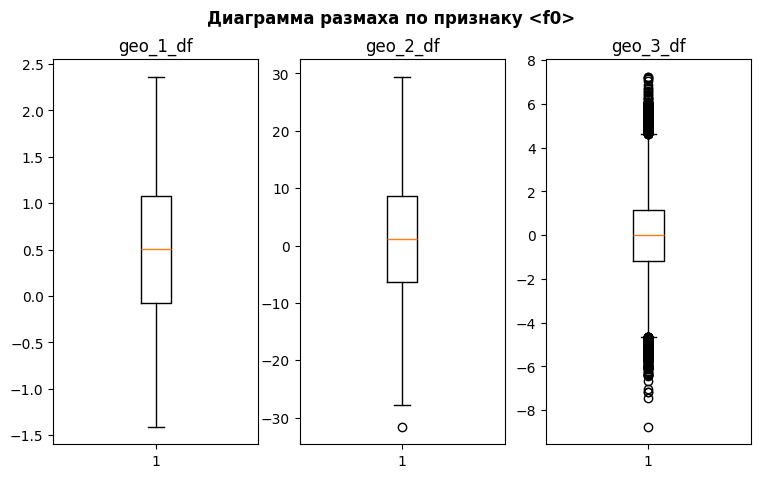

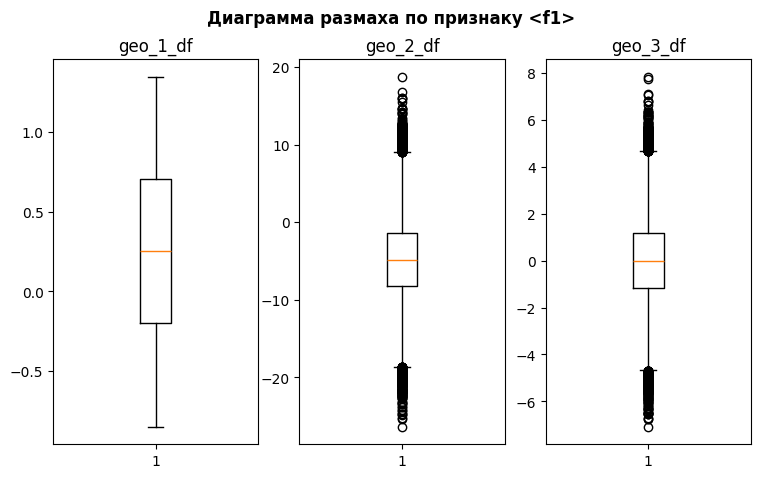

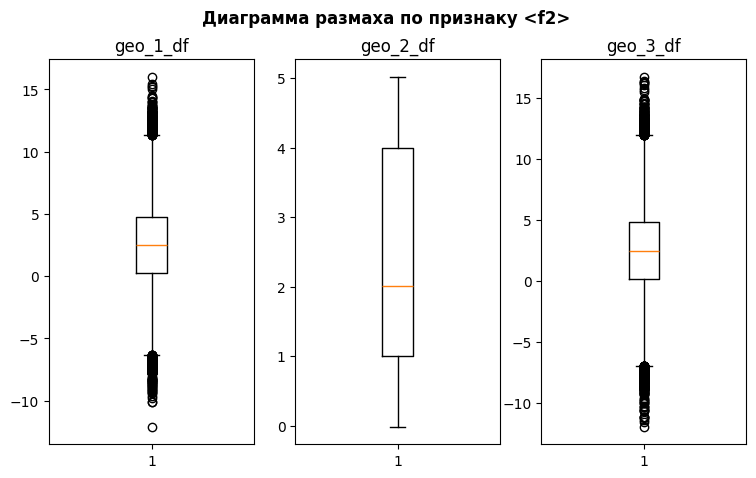

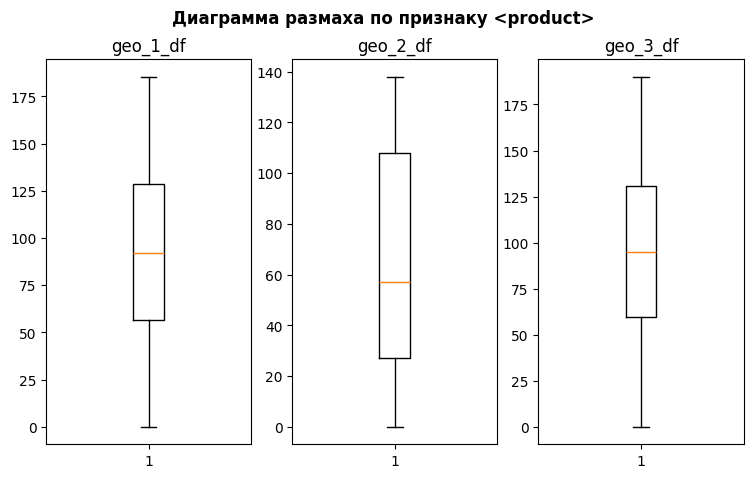

In [28]:
# создание списка признаков
geo_num_lst = geo_1_df.columns.to_list()


# функция для построения диаграммы размаха
def get_boxplot(item):
    plt.rcParams["figure.figsize"] = (
        9,
        5,
    )

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.boxplot(geo_1_df[item])
    ax2.boxplot(geo_2_df[item])
    ax3.boxplot(geo_3_df[item])
    fig.suptitle(
        f"Диаграмма размаха по признаку <{item}>",
        weight="bold",
    )
    ax1.set_title("geo_1_df")
    ax2.set_title("geo_2_df")
    ax3.set_title("geo_3_df")

    plt.show()


# построение графиков
def set_plot(item_lst, plot):
    for item in item_lst:
        plot(item)


# построение диаграмм размаха
set_plot(geo_num_lst, get_boxplot)

На диаграммах размаха по датафрейму **geo_1_df**:
- по признаку `'f2'` - большое количество выбросов ниже и выше края статистически значимой выборки

На диаграммах размаха по датафрейму **geo_2_df**:
- по признаку `'f1'` - большое количество выбросов ниже и выше края статистически значимой выборки

На диаграммах размаха по датафрейму **geo_3_df**:
- по все входящим признакам - большое количество выбросов ниже и выше края статистически значимой выборки

Построим гистограммы распределения

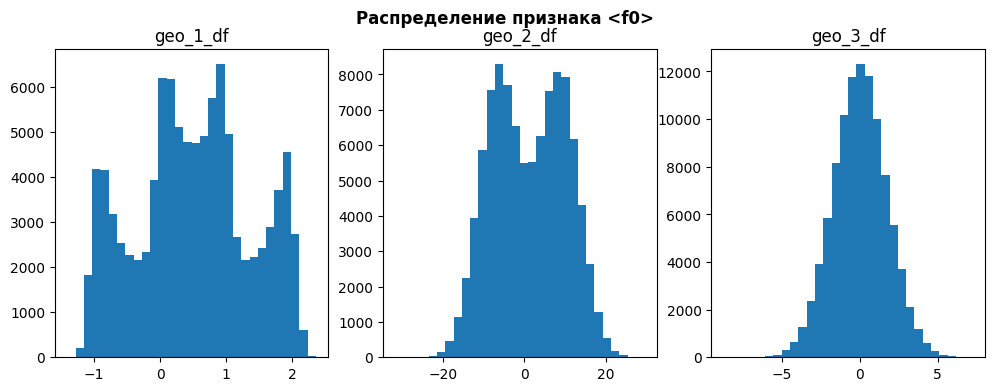

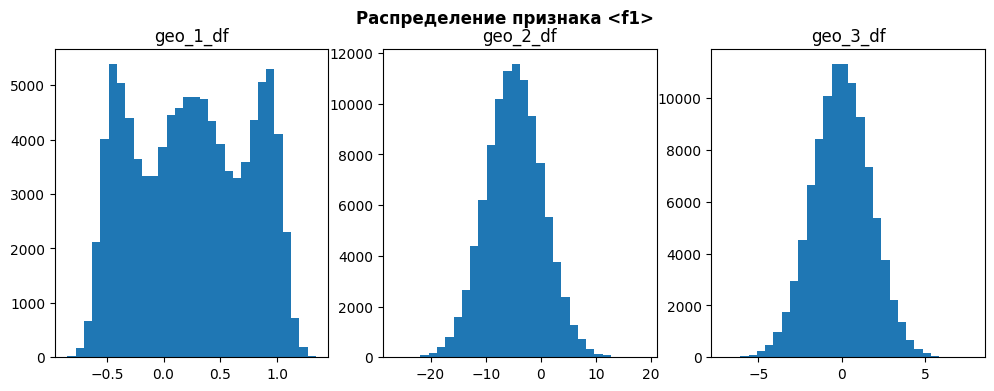

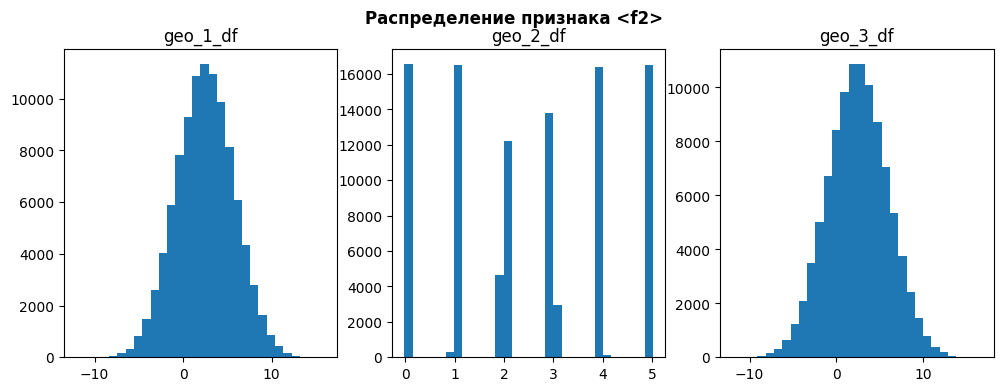

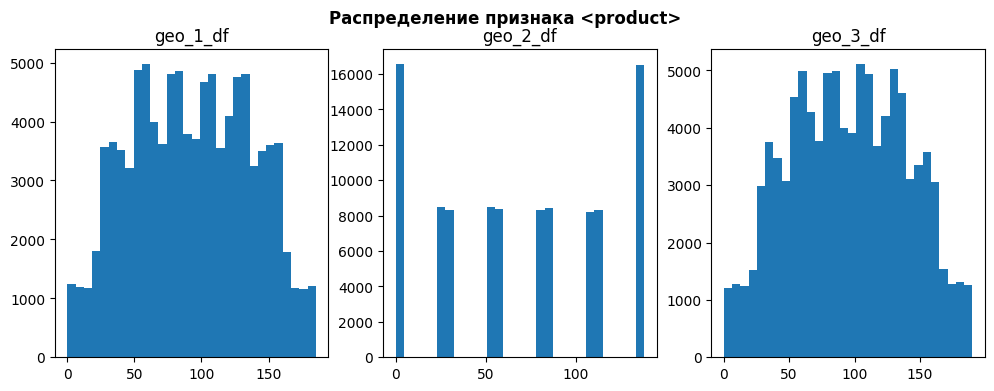

In [29]:
# функция для построения гистограммы
def get_hist(item):
    plt.rcParams["figure.figsize"] = (
        12,
        4,
    )

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.hist(geo_1_df[item], bins=30)
    ax2.hist(geo_2_df[item], bins=30)
    ax3.hist(geo_3_df[item], bins=30)
    plt.suptitle(f"Распределение признака <{item}>", weight="bold")
    ax1.set_title("geo_1_df")
    ax2.set_title("geo_2_df")
    ax3.set_title("geo_3_df")
    plt.show()


# построение гистограмм
set_plot(geo_num_lst, get_hist)

На диаграммах распределения по датафрейму **geo_1_df**:
- по признаку `'f0'` - распределение мультимодальное
- по признаку `'f1'` - распределение мультимодальное
- по признаку `'f2'` - распределение нормальное
- по признаку `'product'` - распределение мультимодальное

На диаграммах распределения по датафрейму **geo_2_df**:
- по признаку `'f0'` - распределение бимодальное
- по признаку `'f1'` - распределение нормальное
- по признаку `'f2'` - распределение мультимодальное
- по признаку `'product'` - распределение мультимодальное

На диаграммах распределения по датафрейму **geo_3_df**:
- по признаку `'f0'` - распределение нормальное
- по признаку `'f1'` - распределение нормальное
- по признаку `'f2'` - распределение нормальное
- по признаку `'product'` - распределение мультимодальное

Проведём корреляционный анализ признаков датафреймов

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


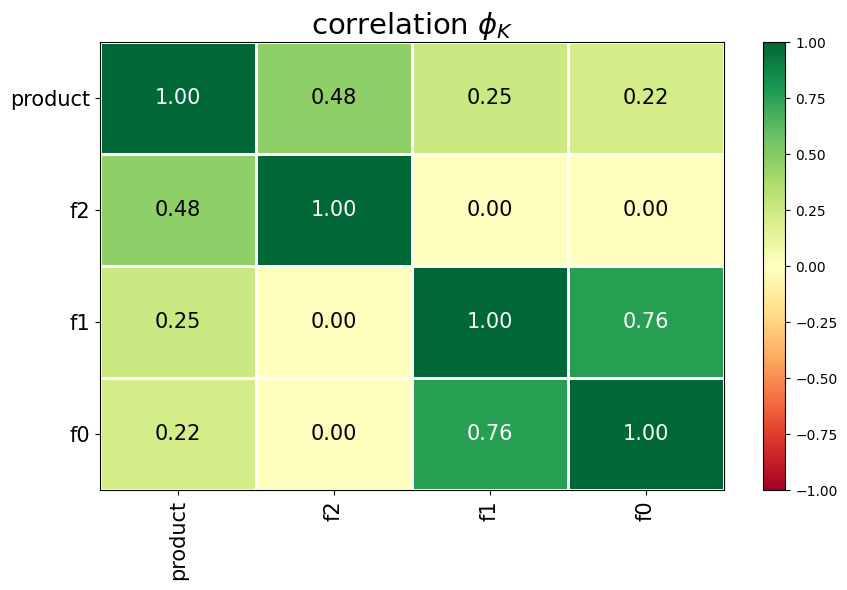

In [30]:
# вычисление коэффициентов корреляции phi
phik_overview = geo_1_df.phik_matrix()

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(9, 6),
)

Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками\
датафрейма **geo_1_df** наблюдается взаимозависимость:
- с входным признаком `'f2'` - умеренная
- с входным признаком `'f0'` - слабая
- с входным признаком `'f1'` - слабая

Также наблюдается высокая взаимосвязь между входными признаками `'f0'` и `'f1'`

Мультиколлинеарность между входящими признаками отсутствует.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


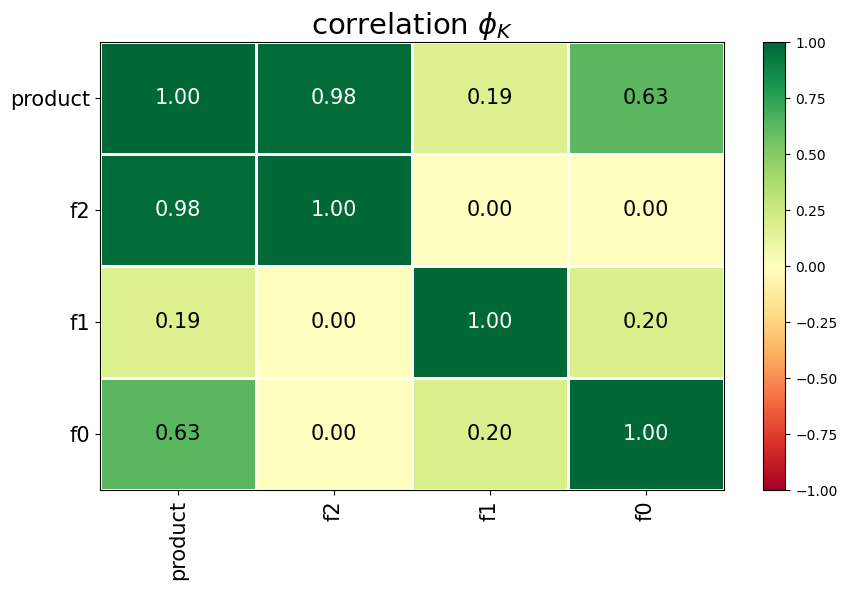

In [31]:
# вычисление коэффициентов корреляции phi
phik_overview = geo_2_df.phik_matrix()

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(9, 6),
)

Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками\
датафрейма **geo_2_df** наблюдается взаимозависимость:
- с входным признаком `'f2'` - весьма высокая
- с входным признаком `'f0'` - заметная
- с входным признаком `'f1'` - слабая

Мультиколлинеарность между входящими признаками отсутствует.

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


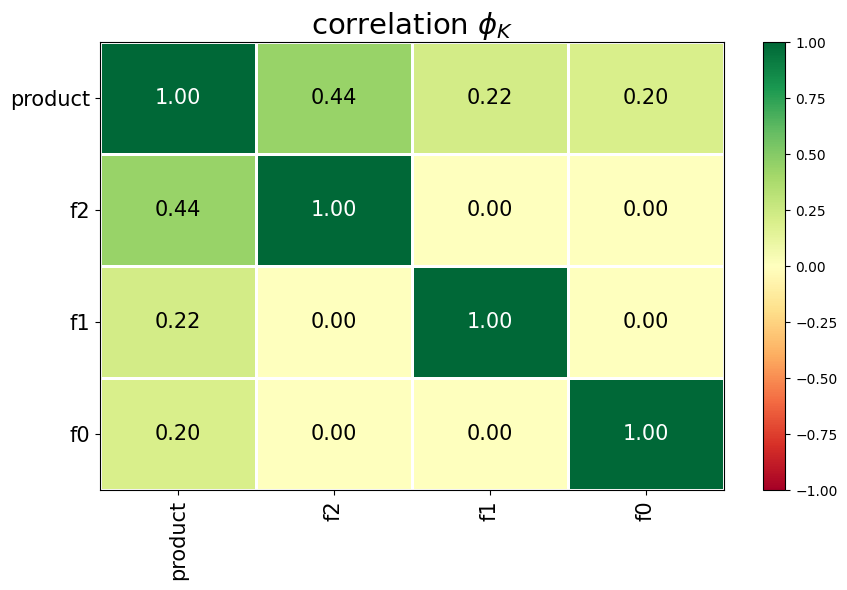

In [32]:
# вычисление коэффициентов корреляции phi
phik_overview = geo_3_df.phik_matrix()

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(9, 6),
)

Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками\
датафрейма **geo_3_df** наблюдается взаимозависимость:
- с входным признаком `'f2'` - умеренная
- с входным признаком `'f1'` - слабая
- с входным признаком `'f0'` - слабая

Мультиколлинеарность между входящими признаками отсутствует.

***

**Вывод:**

В датафреймах по 4 количественных признака: 3 входящих и 1 целевой.

по датафрейму **geo_1_df**

1. По входящим признакам среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по всем признакам достаточно велико, особенно по признаку `'f2'` (3,248).
2. По целевому признаку `'product'` среднее и медиана имеют существенное отличие (92,5 и 91,85).\
    И стандартное отклонение тоже велико (44,289).
3. На диаграммах размаха:
    - по признаку `'f2'` - большое количество выбросов ниже и выше края статистически значимой выборки
4. На диаграммах распределения:
    - по признаку `'f0'` - распределение мультимодальное
    - по признаку `'f1'` - распределение мультимодальное
    - по признаку `'f2'` - распределение нормальное
    - по признаку `'product'` - распределение мультимодальное
5. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
    - с входным признаком `'f2'` - умеренная
    - с входным признаком `'f0'` - слабая
    - с входным признаком `'f1'` - слабая
6. Также наблюдается высокая взаимосвязь между входными признаками `'f0'` и `'f1'`
7. Мультиколлинеарность между входящими признаками отсутствует.

по датафрейму **geo_2_df**

1. По входящим признакам `'f0'` и `'f1'` среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по этим признакам достаточно велико.
2. По признаку `'f2'` среднее (2,495) и медиана (2,011) отличаются существенно,\
    хотя стандартное отклонение не такое большое.
3. По целевому признаку `'product'` среднее и медиана имеют существенное отличие (68,825 и 57,086).\
    И стандартное отклонение тоже велико (45,944).
4. На диаграммах размаха:
    - по признаку `'f1'` - большое количество выбросов ниже и выше края статистически значимой выборки.
5. На диаграммах распределения:
    - по признаку `'f0'` - распределение бимодальное
    - по признаку `'f1'` - распределение нормальное
    - по признаку `'f2'` - распределение мультимодальное
    - по признаку `'product'` - распределение мультимодальное
6. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
    - с входным признаком `'f2'` - весьма высокая
    - с входным признаком `'f0'` - заметная
    - с входным признаком `'f1'` - слабая
7. Мультиколлинеарность между входящими признаками отсутствует.

по датафрейму **geo_3_df**

1. По входящим признакам среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по всем признакам достаточно велико.
2. По целевому признаку `'product'` среднее и медиана не имеют существенного отличия (95 и 94,926).\
    Хотя стандартное отклонение велико (44,75)
3. На диаграммах размаха:
    - по все входящим признакам - большое количество выбросов ниже и выше края статистически значимой выборки
4. На диаграммах распределения:
    - по признаку `'f0'` - распределение нормальное
    - по признаку `'f1'` - распределение нормальное
    - по признаку `'f2'` - распределение нормальное
    - по признаку `'product'` - распределение мультимодальное
5. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
    - с входным признаком `'f2'` - умеренная
    - с входным признаком `'f1'` - слабая
    - с входным признаком `'f0'` - слабая
6. Мультиколлинеарность между входящими признаками отсутствует.

<a id='2'></a>
# Обучение и проверка модели для каждого региона

Так как тагрет - количественный признак, будем решать задачу регрессии.

Будем обучать модель LinearRegression()

Для оценки качества работы модели применим метрику RMSE

Напишем функцию для обучения модели, получения предсказаний и сохранения предсказаний и таргета на валидационной выборке

In [33]:
# объявление функции
def get_predict(df, print_output=True):
    # разделение датафрейма на целевой и входные признаки
    X = df.drop(columns="product")
    y = df["product"]

    # формирование тренировочной и валидационной выборок
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=RANDOM_STATE
    )

    # инициализация модели, обучение и получение предсказаний
    model = LinearRegression()
    model.fit(X_train, y_train)
    pred = model.predict(X_valid)

    # сохранение предсказаний и таргета на валидационной выборке
    union_df = X_valid.join(y_valid)
    union_df["pred"] = pred

    # расчёт метрики rmse
    rmse_score = root_mean_squared_error(y_valid, pred)

    # расчёт среднего предсказаний
    avg_pred = union_df["pred"].mean()

    # вывод значений
    if print_output == True:
        print(
            f"     Средний запас предсказанного сырья - {avg_pred.round(3)} тыс. баррелей"
        )
        print(f"     Оценка качества модели по метрике RMSE- {round(rmse_score, 3)}")

    # возврат рассчитанных значений и нового датафрейма
    return avg_pred, union_df

Выведем средний запас предсказанного сырья и RMSE модели по регионам

In [34]:
print("Средний запас предсказанного сырья и RMSE модели по регионам:")
print(f" - по региону geo_1:")
# вызов функции с выводом значений
avg_pred_1, union_df_1 = get_predict(geo_1_df)
print(f" - по региону geo_2:")
avg_pred_2, union_df_2 = get_predict(geo_2_df)
print(f" - по региону geo_3:")
avg_pred_3, union_df_3 = get_predict(geo_3_df)

Средний запас предсказанного сырья и RMSE модели по регионам:
 - по региону geo_1:
     Средний запас предсказанного сырья - 92.399 тыс. баррелей
     Оценка качества модели по метрике RMSE- 37.757
 - по региону geo_2:
     Средний запас предсказанного сырья - 68.713 тыс. баррелей
     Оценка качества модели по метрике RMSE- 0.89
 - по региону geo_3:
     Средний запас предсказанного сырья - 94.771 тыс. баррелей
     Оценка качества модели по метрике RMSE- 40.146


***

**Вывод:**

1. Была написана функция для обучения модели и получения предсказаний
2. Были получены предсказания на валидационных выборках датафреймов
3. Были получены метрики оценки качества моделей

|Датафрейм|Средний запас предсказанного сырья, тыс.баррелей|Средняя оценка качества модели RMSE|
|:-|:-:|:-:|
|geo_1_df|92.399|37.757|
|geo_2_df|68.713|0.890|
|geo_3_df|94.771|40.146|

4. Средний запас предсказанного сырья выше в регионе geo_3,\
    а самый низкий - в регионе geo_2
5. Метрика RMSE показывает лучшее качество модели для региона geo_2

<a id='3'></a>
# Подготовка к расчёту прибыли

Сохраним значения для расчётов в переменных

In [35]:
# объявление значений констант
REG_BUDGET = 10_000_000_000  # бюджет на регион
WELL_COUNT = 500  # количество скважин для исследования
BEST_WELL_COUNT = 200  # количество лучших скважин
UNIT_REVENUE = 450_000  # доход с единицы продукта

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [36]:
# объявление функции для расчёта
def get_suff_product():
    # расчёт бюджета на скважину
    well_budget = REG_BUDGET / BEST_WELL_COUNT

    # расчёт достаточного объёма сырья
    suff_product = well_budget / UNIT_REVENUE
    return suff_product


# вывод полученного значения безубыточности
print(
    f"Достаточный объём сырья составляет {round(get_suff_product(), 3)} тыс. баррелей"
)

Достаточный объём сырья составляет 111.111 тыс. баррелей


Сравним полученный объём сырья со средним запасом по каждому региону.

In [37]:
print(f"Средний запас сырья по региону geo_1 - {avg_pred_1.round(3)} тыс. баррелей")
print(
    f"   - это меньше достаточного объёма на {round(get_suff_product()- avg_pred_1, 3)} тыс. баррелей"
)
print(f"Средний запас сырья по региону geo_2 - {avg_pred_2.round(3)} тыс. баррелей")
print(
    f"   - это меньше достаточного объёма на {round(get_suff_product()- avg_pred_2, 3)} тыс. баррелей"
)
print(f"Средний запас сырья по региону geo_2 - {avg_pred_3.round(3)} тыс. баррелей")
print(
    f"   - это меньше достаточного объёма на {round(get_suff_product()- avg_pred_3, 3)} тыс. баррелей"
)

Средний запас сырья по региону geo_1 - 92.399 тыс. баррелей
   - это меньше достаточного объёма на 18.712 тыс. баррелей
Средний запас сырья по региону geo_2 - 68.713 тыс. баррелей
   - это меньше достаточного объёма на 42.398 тыс. баррелей
Средний запас сырья по региону geo_2 - 94.771 тыс. баррелей
   - это меньше достаточного объёма на 16.34 тыс. баррелей


***

**Вывод:**

1. Значения для расчётов были сохранены в константах
2. Был рассчитан достаточный объём сырья для безубыточной разработки новой скважины - 111,111 тыс. баррелей
3. Средний запас предсказанного сырья по всем регионам меньше, чем достаточный на:
    - по региону geo_1 на 18,712 тыс. баррелей
    - по региону geo_2 на 42,398 тыс. баррелей
    - по региону geo_3 на 16,34 тыс. баррелей

# Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели

In [38]:
# объявление функции для расчёта прибыли
def get_profit(df, count):
    # выбор скважин с максимальными значениями предсказаний
    selected_df = df.sort_values("pred", ascending=False)[:count]

    # суммирование целевого значения, соответствующего максимальным значениям
    product_sum = selected_df["product"].sum()

    # расчёт прибыли для полученного объёма сырья
    profit = product_sum * UNIT_REVENUE - REG_BUDGET
    return profit

Рассчитаем прибыль для полученного объёма сырья по регионам

In [39]:
print("Прибыль для полученного объёма сырья по регионам:")
print(f" - по региону geo_1 - {get_profit(union_df_1, BEST_WELL_COUNT):,.3f} руб.")
print(f" - по региону geo_2 - {get_profit(union_df_2, BEST_WELL_COUNT):,.3f} руб.")
print(f" - по региону geo_3 - {get_profit(union_df_3, BEST_WELL_COUNT):,.3f} руб.")

Прибыль для полученного объёма сырья по регионам:
 - по региону geo_1 - 3,359,141,114.462 руб.
 - по региону geo_2 - 2,415,086,696.682 руб.
 - по региону geo_3 - 2,598,571,759.374 руб.


***

**Вывод:**

1. Была написана функция для расчёта прибыли по по выбранным скважинам и предсказаниям модели
2. Рассчитанная прибыль по регионам составила:
   - по региону geo_1  -   3_359_141_114.462 руб.
   - по региону geo_2  -   2_415_086_696.682 руб.
   - по региону geo_3  -   2_598_571_759.374 руб.

# Расчёт рисков и прибыли для каждого региона

Напишем функцию для рассчёта рисков и прибыли

In [40]:
# объявление функции с техникой бутстрепа для рассчёта прибыли и рисков
def get_statistics(df, count):
    # обучение модели
    avg_pred, union_df = get_predict(df, print_output=False)

    # объявление переменной
    profits = []

    # применение техники бутстреп с сохранением значения прибыли в список
    for i in range(1000):
        subsample = union_df.sample(500, replace=True, random_state=i)
        profits.append(get_profit(subsample, count))

    # нахождение доверительного интервала для прибыли
    ci = np.percentile(profits, [2.5, 97.5])

    # создание Series из списка
    profits = pd.Series(profits)

    # средняя прибыль
    mean_profit = profits.mean()

    # вычисление риска убытков
    loss_risk = float((profits < 0).mean()) * 100

    # возврат значений
    return ci, mean_profit, loss_risk, profits

Рассчитаем показатели для каждого региона

In [41]:
# рассчёт показателей
ci_1, mean_profit_1, loss_risk_1, _ = get_statistics(geo_1_df, BEST_WELL_COUNT)
ci_2, mean_profit_2, loss_risk_2, _ = get_statistics(geo_2_df, BEST_WELL_COUNT)
ci_3, mean_profit_3, loss_risk_3, _ = get_statistics(geo_3_df, BEST_WELL_COUNT)

Выведем рассчитанные показатели по регионам

In [42]:
print("Средняя прибыль составляет:")
print(f" - по региону geo_1 - {mean_profit_1/1000:,.1f} тыс.рублей")
print(f" - по региону geo_2 - {mean_profit_2/1000:,.1f} тыс.рублей")
print(f" - по региону geo_3 - {mean_profit_3/1000:,.1f} тыс.рублей")
print(" ")
print("95% доверительный интервал для средней прибыли:")
print(
    f" - по региону geo_1 - [{ci_1[0]/1000:,.1f} тыс.рублей, {ci_1[1]/1000:,.1f} тыс.рублей]"
)
print(
    f" - по региону geo_2 - [{ci_2[0]/1000:,.1f} тыс.рублей, {ci_2[1]/1000:,.1f} тыс.рублей]"
)
print(
    f" - по региону geo_3 - [{ci_3[0]/1000:,.1f} тыс.рублей, {ci_3[1]/1000:,.1f} тыс.рублей]"
)
print(" ")
print("Риск убытков составляет:")
print(f" - по региону geo_1 - {round(loss_risk_1, 1)}%")
print(f" - по региону geo_2 - {round(loss_risk_2, 1)}%")
print(f" - по региону geo_3 - {round(loss_risk_3, 1)}%")

Средняя прибыль составляет:
 - по региону geo_1 - 401,429.0 тыс.рублей
 - по региону geo_2 - 441,099.4 тыс.рублей
 - по региону geo_3 - 376,818.2 тыс.рублей
 
95% доверительный интервал для средней прибыли:
 - по региону geo_1 - [-103,041.2 тыс.рублей, 938,618.4 тыс.рублей]
 - по региону geo_2 - [52,213.0 тыс.рублей, 812,355.6 тыс.рублей]
 - по региону geo_3 - [-144,751.0 тыс.рублей, 908,999.0 тыс.рублей]
 
Риск убытков составляет:
 - по региону geo_1 - 6.1%
 - по региону geo_2 - 1.4%
 - по региону geo_3 - 8.6%


Визуализируем распределение средней прибыли по датафреймам

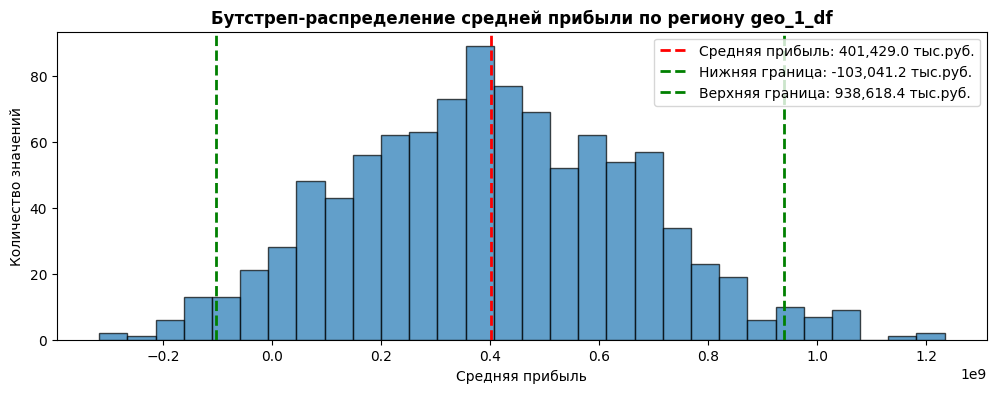

In [43]:
# функция для визуализации распределения средней прибыли
def get_hist_profit(df):
    ci, mean_profit, _, profits = get_statistics(df, BEST_WELL_COUNT)
    plt.hist(profits, bins=30, edgecolor="k", alpha=0.7)
    plt.axvline(
        mean_profit,
        color="red",
        linestyle="dashed",
        linewidth=2,
        label=f"Средняя прибыль: {mean_profit/1000:,.1f} тыс.руб.",
    )
    plt.axvline(
        ci[0],
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Нижняя граница: {ci[0]/1000:,.1f} тыс.руб.",
    )
    plt.axvline(
        ci[1],
        color="green",
        linestyle="dashed",
        linewidth=2,
        label=f"Верхняя граница: {ci[1]/1000:,.1f} тыс.руб.",
    )
    plt.legend()
    plt.title(
        f"Бутстреп-распределение средней прибыли по региону {df.name}", weight="bold"
    )
    plt.xlabel("Средняя прибыль")
    plt.ylabel("Количество значений")
    plt.show()


# вызов функции для датафрейма geo_1_df
get_hist_profit(geo_1_df)

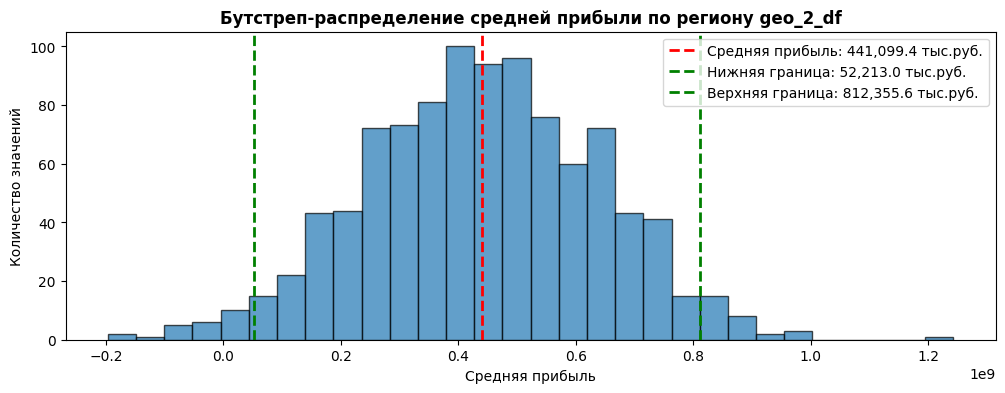

In [44]:
# вызов функции для датафрейма geo_2_df
get_hist_profit(geo_2_df)

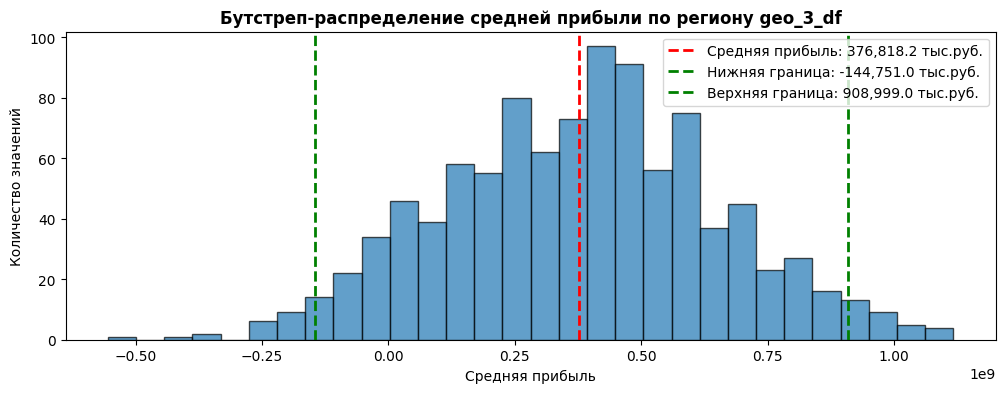

In [45]:
# вызов функции для датафрейма geo_3_df
get_hist_profit(geo_3_df)

***

**Вывод:**

1. Для расчёта прибыли и рисков была применена техника бутстреп
2. Были рассчитаны показатели по регионам:
    - средняя прибыль
    - 95%-й доверительный интервал для средней прибыли
    - риск убытков
3. Рассчитанные показатели приведены в таблице:

   |Регион|Средняя прибыль, тыс.руб.|95%-й доверительный интервал, тыс.руб.|Риск убытков|
   |-|:-:|:-:|:-:|
   |geo_1|401,429.0|[-103,041.2, 938,618.4]|6,1%|
   |geo_2|441,099.4|[52,213.0, 812,355.6]|1.4%|
   |geo_3|376,818.2|[-144,751.0, 908,999.0]|8.6%|

4. Так как только регион geo_2 с вероятностью риска убытков ниже 2,5%,\
    то для разработки скважин можно предложить только этот регион.

# Общий вывод

**ВХОДНЫЕ ДАННЫЕ**

1. Исследование проведено на основе данных добывающей компании "ГлавРосГосНефть"
2. Данные представлены файлами:
    - geo_data_0.csv
    - geo_data_1.csv
    - geo_data_2.csv
3. Данные загружены в датафреймы.
4. Пропуски в данных отсутствуют.
5. Наименования столбцов во всех датафреймах имеют стандартный вид.

**НА ЭТАПЕ ПРЕОБРАБОТКИ ДАННЫХ**

1. Явные дубликаты в датафреймах отсутствуют
2. Во всех датафреймах были установлены ID как индексы.

**НА ЭТАПЕ ИССЛЕДОВАТЕЛЬСКОГО АНАЛИЗА ДАННЫХ**

По датафреймам было выявлено:

В датафреймах по 4 количественных признака: 3 входящих и 1 целевой.

по датафрейму **geo_1_df**

1. По входящим признакам среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по всем признакам достаточно велико, особенно по признаку `'f2'` (3,248).
2. По целевому признаку `'product'` среднее и медиана имеют существенное отличие (92,5 и 91,85).\
    И стандартное отклонение тоже велико (44,289).
3. На диаграммах размаха:
    - по признаку `'f2'` - большое количество выбросов ниже и выше края статистически значимой выборки
4. На диаграммах распределения:
    - по признаку `'f0'` - распределение мультимодальное
    - по признаку `'f1'` - распределение мультимодальное
    - по признаку `'f2'` - распределение нормальное
    - по признаку `'product'` - распределение мультимодальное
5. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
   - с входным признаком `'f2'` - умеренная
   - с входным признаком `'f0'` - слабая
   - с входным признаком `'f1'` - слабая
6. Мультиколлинеарность между входящими признаками отсутствует.

по датафрейму **geo_2_df**

1. По входящим признакам `'f0'` и `'f1'` среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по этим признакам достаточно велико.
2. По признаку `'f2'` среднее (2,495) и медиана (2,011) отличаются существенно,\
    хотя стандартное отклонение не такое большое.
3. По целевому признаку `'product'` среднее и медиана имеют существенное отличие (68,825 и 57,086).\
    И стандартное отклонение тоже велико (45,944).
4. На диаграммах размаха:
    - по признаку `'f1'` - большое количество выбросов ниже и выше края статистически значимой выборки.
5. На диаграммах распределения:
    - по признаку `'f0'` - распределение бимодальное
    - по признаку `'f1'` - распределение нормальное
    - по признаку `'f2'` - распределение мультимодальное
    - по признаку `'product'` - распределение мультимодальное
6. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
    - с входным признаком `'f2'` - весьма высокая
    - с входным признаком `'f0'` - заметная
    - с входным признаком `'f1'` - слабая
7. Мультиколлинеарность между входящими признаками отсутствует.

по датафрейму **geo_3_df**

1. По входящим признакам среднее и медиана отличаются несущественно,\
    хотя стандартное отклонение по всем признакам достаточно велико.
2. По целевому признаку `'product'` среднее и медиана не имеют существенного отличия (95 и 94,926).\
    Хотя стандартное отклонение велико (44,75)
3. На диаграммах размаха:
    - по все входящим признакам - большое количество выбросов ниже и выше края статистически значимой выборки
4. На диаграммах распределения:
    - по признаку `'f0'` - распределение нормальное
    - по признаку `'f1'` - распределение нормальное
    - по признаку `'f2'` - распределение нормальное
    - по признаку `'product'` - распределение мультимодальное
5. Согласно шкале Чеддока между целевым признаком `'product'` и входными признаками наблюдается взаимозависимость:
    - с входным признаком `'f2'` - умеренная
    - с входным признаком `'f1'` - слабая
    - с входным признаком `'f0'` - слабая
6. Мультиколлинеарность между входящими признаками отсутствует.


**НА ЭТАПЕ ОБУЧЕНИЯ МОДЕЛЕЙ**

1. Была написана функция для обучения модели и получения предсказаний
2. Были получены предсказания на валидационных выборках датафреймов
3. Были получены метрики оценки качества моделей

|Датафрейм|Средний запас предсказанного сырья, тыс.баррелей|Средняя оценка качества модели RMSE|
|:-|:-:|:-:|
|geo_1_df|92.399|37.757|
|geo_2_df|68.713|0.890|
|geo_3_df|94.771|40.146|

4. Средний запас предсказанного сырья выше в регионе geo_3,\
    а самый низкий - в регионе geo_2
5. Метрика RMSE показывает лучшее качество модели для региона geo_2

**НА ЭТАПЕ ПОДГОТОВКИ К РАСЧЁТУ ПРИБЫЛИ**

1. Значения для расчётов были сохранены в константах
2. Был рассчитан достаточный объём сырья для безубыточной разработки новой скважины - 111,111 тыс. баррелей
3. Средний запас предсказанного сырья по всем регионам меньше, чем достаточный на:
    - по региону geo_1 на 18,712 тыс. баррелей
    - по региону geo_2 на 42,398 тыс. баррелей
    - по региону geo_3 на 16,34 тыс. баррелей

**НА ЭТАПЕ ФУНКЦИИ ДЛЯ РАСЧЁТА ПРИБЫЛИ ПО ВЫБРАННЫМ СКВАЖИНАМ И ПРЕДСКАЗАНИЯМ МОДЕЛИ**

1. Была написана функция для расчёта прибыли по по выбранным скважинам и предсказаниям модели
2. Рассчитанная прибыль по регионам составила:
   - по региону geo_1  -   3_359_141_114.462 руб.
   - по региону geo_2  -   2_415_086_696.682 руб.
   - по региону geo_3  -   2_598_571_759.374 руб.

**НА ЭТАПЕ РАСЧЁТА РИСКОВ И ПРИБЫЛИ ДЛЯ КАЖДОГО РЕГИОНА**

1. Для расчёта прибыли и рисков была применена техника бутстреп
2. Были рассчитаны показатели по регионам:
    - средняя прибыль
    - 95%-й доверительный интервал для средней прибыли
    - риск убытков
3. Рассчитанные показатели приведены в таблице:

   |Регион|Средняя прибыль, тыс.руб.|95%-й доверительный интервал, тыс.руб.|Риск убытков|
   |-|:-:|:-:|:-:|
   |geo_1|401,429.0|[-103,041.2, 938,618.4]|6,1%|
   |geo_2|441,099.4|[52,213.0, 812,355.6]|1.4%|
   |geo_3|376,818.2|[-144,751.0, 908,999.0]|8.6%|

**ВЫВОД**

1. Так как только регион geo_2 с вероятностью риска убытков ниже 2,5%,\
    то для разработки скважин можно предложить только этот регион.